In [1]:
import time
import math

import pandas as pd
import numpy as np

import torch as torch
import torch.utils.data as data
from torch.utils.data import Dataset

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import itertools
import sqlite3
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Описание выбранного подхода и краткий обзор других

Выбранный подход - Factorization Machines. Это модель машинного обучения, которая расширяет традиционную матричную факторизацию за счет изучения взаимодействий между различными значениями признаков модели. Преимуществом FM является то, что она решает проблему "холодного старта", можно делать прогнозы на основе метаданных пользователя (которые скорее всего есть в боевой системе), даже если это пользователь, которого система никогда раньше не видела. После обучения модели вектора могут уловить некую "семантику", как word2vec эмбеддинги, поэтому ожидается, что они могут показывать схожесть пользователей и фильмов.

Альтернативные подходы:
Методы матричной факторизации, такие как SVD, ALS, отпали, поскольку они требуют слишком много оперативной памяти, как для хранения таблицы со всеми данными, так и для вычисления матриц UV. Есть Incremental SVD, Incremental PCA, но в условии задачи также было **выделено** использование **нейросетевых подходов**.

Bert Embedding - мало данных и описательных характеристик фильмов и пользователей

# Обработка данных

In [3]:
DB_PATH = "/kaggle/input/deepfashion-ratings-dataset-12k/user_ratings.db"

In [4]:
# Загрузка из SQL DB
db_conn = sqlite3.connect(DB_PATH)
sql_query = pd.read_sql_query('''
                              select * from ratings
                              '''
                              ,db_conn) 
ratings_df = pd.DataFrame(sql_query)
db_conn.close()

In [6]:
ratings_df.drop_duplicates(subset=['user_id', 'image_id'], keep='first', inplace=True)
ratings_df

,user_id,image_id,rating
0,159,img/Be_True_Graphic_Tunic_Tank/img_00000021.jpg,4
1,159,img/Zippered_Fit_&_Flare_Dress/img_00000007.jpg,2
2,159,img/Sheer-Sleeved_Pleated_Romper/img_00000004.jpg,5
3,159,img/Crossback_Surplice_Jumpsuit/img_00000026.jpg,3
4,159,img/Woven_Wrap_Cardigan/img_00000067.jpg,0
...,...,...,...
11918,199,img/Iconic_V-Neck_Cardigan/img_00000004.jpg,0
11919,199,img/Heathered_Baseball_Stripe_Tee/img_00000002...,0
11920,199,img/Ribbed_Drawstring_Joggers/img_00000025.jpg,0
11921,199,img/Paneled_Baseball_Tee/img_00000008.jpg,4


In [7]:
ratings_df["clothes_id"] = ratings_df.groupby("image_id").ngroup()
clothes_df = ratings_df[["image_id", "clothes_id"]]
clothes_df

,image_id,clothes_id
0,img/Be_True_Graphic_Tunic_Tank/img_00000021.jpg,483
1,img/Zippered_Fit_&_Flare_Dress/img_00000007.jpg,8011
2,img/Sheer-Sleeved_Pleated_Romper/img_00000004.jpg,6255
3,img/Crossback_Surplice_Jumpsuit/img_00000026.jpg,2104
4,img/Woven_Wrap_Cardigan/img_00000067.jpg,7944
...,...,...
11918,img/Iconic_V-Neck_Cardigan/img_00000004.jpg,4175
11919,img/Heathered_Baseball_Stripe_Tee/img_00000002...,3837
11920,img/Ribbed_Drawstring_Joggers/img_00000025.jpg,5917
11921,img/Paneled_Baseball_Tee/img_00000008.jpg,5452


In [8]:
# Столбцы, которые будут использоваться как признаки
feature_columns = ['user_id','clothes_id']

In [9]:
# Количество уникальных фильмов
n_clothes_unique = len(ratings_df['clothes_id'].unique())
n_clothes_unique

8045

In [10]:
# Количество уникальных пользователей
n_user_unique = len(ratings_df['user_id'].unique())
n_user_unique

34

In [11]:
# Получает "размер" идентификаторов
features_sizes = {
    'user_id': n_user_unique,
    'clothes_id': n_user_unique,
}

# Считает смещение идентификатора, 
# поскольку всё в одном пространстве.

# Следующий ид признака идет сразу после предыдущего
next_offset = 0
features_offsets={}
for k,v in features_sizes.items():
    features_offsets[k] = next_offset
    next_offset += v

In [12]:
# Смещает все индексы в датасете
for column in feature_columns:
    ratings_df[column] = ratings_df[column].apply(lambda c: c + features_offsets[column])   

In [13]:
ratings_df[[*feature_columns,'rating']].head()

,user_id,clothes_id,rating
0,159,517,4
1,159,8045,2
2,159,6289,5
3,159,2138,3
4,159,7978,0


In [14]:
data_x = torch.tensor(ratings_df[feature_columns].values)    # user_id, clothes_id
data_y = torch.tensor(ratings_df['rating'].values).float()   # rating - таргет
dataset = data.TensorDataset(data_x, data_y)

In [26]:
bs = 32                            # Размер батча
train_n = int(len(dataset) * 0.9)    # Размер тренировочной выборки
valid_n = len(dataset) - train_n     # Размер валидационной выборки
splits = [train_n, valid_n]

trainset, devset = torch.utils.data.random_split(dataset, splits)
train_dataloader = data.DataLoader(trainset, batch_size=bs, shuffle=True)
dev_dataloader = data.DataLoader(devset, batch_size=bs, shuffle=True)

In [16]:
# Взята из fast.ai
# Эта функция инициализирует тензор x со значениями, 
# распределенными по нормальному закону с заданным средним значением и стандартным отклонением.
# Однако, она также обрезает значения, которые находятся за пределами двух стандартных отклонений от среднего, 
# чтобы избежать влияния выбросов на инициализацию.
def trunc_normal_(x, mean=0., std=1.):
    "Truncated normal initialization."
    return x.normal_().fmod_(2).mul_(std).add_(mean)

# Обучение модели

In [17]:
class FMModel(nn.Module):
    def __init__(self, n, k):
        super().__init__()

        self.w0 = nn.Parameter(torch.zeros(1))
        self.bias = nn.Embedding(n, 1)
        
        # При передаче индекса в Embedding слой, 
        # он использует этот индекс для извлечения соответствующего вектора из матрицы 
        # и возвращает его
        self.embeddings = nn.Embedding(n, k)

        with torch.no_grad(): trunc_normal_(self.embeddings.weight, std=0.01)
        with torch.no_grad(): trunc_normal_(self.bias.weight, std=0.01)

    def forward(self, X):
        emb = self.embeddings(X)
        pow_of_sum = emb.sum(dim=1).pow(2)
        sum_of_pow = emb.pow(2).sum(dim=1)
        pairwise = (pow_of_sum - sum_of_pow).sum(1) * 0.5
        bias = self.bias(X).squeeze().sum(1)
        return torch.sigmoid(self.w0 + bias + pairwise) * 5.5

In [18]:
# Обучает модель
def fit(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    for x, y in iterator:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item() * x.shape[0]
        loss.backward()
        optimizer.step()
    return train_loss / len(iterator.dataset)

# Валидирует модель
def test(iterator, model, criterion):
    train_loss = 0
    model.eval()
    for x,y in iterator:                    
        with torch.no_grad():
            y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item() * x.shape[0]
    return train_loss / len(iterator.dataset)

Выбор MSE в качестве лосс функции:

Сам по себе MSE измеряет близость между векторами, а также относительное расположение векторов в пространстве, что отлично подходит для задачи генерации эмбеддингов. 

In [19]:
# Проходит по эпохам обучения
def train_n_epochs(model, n, optimizer,scheduler):
    criterion = nn.MSELoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss = fit(train_dataloader, model, optimizer, criterion)
        valid_loss = test(dev_dataloader, model, criterion)
        scheduler.step()
        secs = int(time.time() - start_time)
        print(f'epoch {epoch}. time: {secs}[s]')
        print(f'\ttrain rmse: {(math.sqrt(train_loss)):.4f}')
        print(f'\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}')

Использование weight decay: В оптимизаторе Adam weight decay добавляется как L2-регуляризация к градиентам весов при обновлении параметров модели. Это позволяет уменьшить значения весов на каждой итерации обучения и снизить их влияние на функцию потерь. Мотивацией для выбора является неприлично огромный датасет.

Использование Scheduler для шагов оптимизатора: использование Scheduler для изменения learning rate в процессе обучения позволяет более точно настроить скорость обучения для каждой фазы обучения, что может улучшить качество модели за счет быстрого обучения в начале и более точного обновления весов в более поздних эпохах.


In [41]:
 data_x.max()

tensor(8078)

In [27]:
model = FMModel(data_x.max() + 1, 120).to(device)
wd = 1e-5    # Weight decay для оптимизатора
lr = 0.001
epochs=15
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.1)
criterion = nn.MSELoss().to(device)
for epoch in range(epochs):
    start_time = time.time()
    train_loss = fit(train_dataloader, model, optimizer, criterion)
    valid_loss = test(dev_dataloader, model, criterion)
    scheduler.step()
    secs = int(time.time() - start_time)
    print(f'epoch {epoch}. time: {secs}[s]')
    print(f'\ttrain rmse: {(math.sqrt(train_loss)):.4f}')
    print(f'\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}')

epoch 0. time: 3[s]
	train rmse: 2.2058
	validation rmse: 1.9821
epoch 1. time: 2[s]
	train rmse: 1.6669
	validation rmse: 1.7845
epoch 2. time: 2[s]
	train rmse: 1.0268
	validation rmse: 1.7952
epoch 3. time: 3[s]
	train rmse: 0.6471
	validation rmse: 1.7793
epoch 4. time: 3[s]
	train rmse: 0.4628
	validation rmse: 1.7709
epoch 5. time: 3[s]
	train rmse: 0.3634
	validation rmse: 1.7643
epoch 6. time: 3[s]
	train rmse: 0.3045
	validation rmse: 1.7553
epoch 7. time: 3[s]
	train rmse: 0.2764
	validation rmse: 1.7546
epoch 8. time: 3[s]
	train rmse: 0.2586
	validation rmse: 1.7534
epoch 9. time: 3[s]
	train rmse: 0.2450
	validation rmse: 1.7525
epoch 10. time: 3[s]
	train rmse: 0.2339
	validation rmse: 1.7517
epoch 11. time: 3[s]
	train rmse: 0.2246
	validation rmse: 1.7507
epoch 12. time: 3[s]
	train rmse: 0.2166
	validation rmse: 1.7496
epoch 13. time: 3[s]
	train rmse: 0.2096
	validation rmse: 1.7485
epoch 14. time: 3[s]
	train rmse: 0.2033
	validation rmse: 1.7473


In [28]:
clothes = ratings_df.drop_duplicates("clothes_id").copy()
clothes_embeddings = model.embeddings(torch.tensor(clothes["clothes_id"].values, device=device).long())
clothes["embedding"] = clothes_embeddings.tolist()
clothes_biases = model.bias(torch.tensor(clothes["clothes_id"].values, device=device))
clothes['bias'] = clothes_biases.cpu().detach().numpy()

In [94]:
clothes[['image_id','clothes_id','embedding','bias']].head(50)

,image_id,clothes_id,embedding,bias
0,img/Be_True_Graphic_Tunic_Tank/img_00000021.jpg,517,"[0.06372121721506119, -0.06790578365325928, -0...",5.213659e-02
1,img/Zippered_Fit_&_Flare_Dress/img_00000007.jpg,8045,"[-0.0007592144538648427, -0.001601429306901991...",-5.579891e-03
2,img/Sheer-Sleeved_Pleated_Romper/img_00000004.jpg,6289,"[0.10127484798431396, -0.11252811551094055, -0...",7.353294e-02
3,img/Crossback_Surplice_Jumpsuit/img_00000026.jpg,2138,"[0.048901405185461044, -0.023373140022158623, ...",8.369518e-03
4,img/Woven_Wrap_Cardigan/img_00000067.jpg,7978,"[-0.09120453149080276, 0.09655192494392395, 0....",-5.978131e-02
5,img/L.A._Graphic_Tee/img_00000029.jpg,4346,"[-0.017614152282476425, 0.1365310698747635, -0...",-9.387077e-02
6,img/Crochet_Cami_Strap_Dress/img_00000009.jpg,2044,"[0.0769786685705185, 0.02695910818874836, -0.0...",-2.812136e-02
7,img/Chevron_Print_Cami_Maxi_Dress/img_00000011...,1269,"[-0.041868723928928375, 0.04106098413467407, 0...",-3.192496e-02
8,img/Paisley_Tunic_Dress/img_00000064.jpg,5459,"[-0.03468586876988411, 0.06007729470729828, -0...",-6.743030e-02
9,img/Blurred_Floral_Bomber_Jacket/img_00000013.jpg,729,"[0.045326944440603256, 0.14487236738204956, -0...",-7.621151e-02


In [42]:
clothes[clothes.clothes_id == 6698]

,user_id,image_id,rating,clothes_id,embedding,bias
8151,191,img/Strapless_Romper/img_00000045.jpg,4,6698,"[-0.04198956862092018, -0.04175354167819023, 0...",0.039826


# Применение модели

### Поиск похожих фильмов

In [31]:
!pip install gdown

In [34]:
import gdown
import zipfile

# Загрузка изображений (289222 объекта)
root_path = './'
url = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
output = 'images.zip'
gdown.download(url, output, quiet=False)

with zipfile.ZipFile("images.zip","r") as zip_ref:
    zip_ref.extractall(root_path)


Downloading...
From (uriginal): https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
From (redirected): https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb&confirm=t&uuid=26830c00-1a3c-4279-ba3c-a63998a322b1
To: /kaggle/working/images.zip
100%|██████████| 2.68G/2.68G [00:17<00:00, 157MB/s] 


In [45]:
strapless_romper_index = torch.tensor(6698).to(device)
strapless_romper_embedding = model.embeddings(strapless_romper_index)
cosine_similarities = torch.tensor([F.cosine_similarity(strapless_romper_embedding,i,dim=0) for i in clothes_embeddings])
top = clothes.iloc[cosine_similarities.argsort(descending=True).detach().numpy()]['image_id'].values[:10]
top

array(['img/Strapless_Romper/img_00000045.jpg',
       'img/Textured_Funnel_Neck_Dress/img_00000018.jpg',
       'img/Harry_Potter_Muscle_Tee/img_00000045.jpg',
       'img/Embroidered_Lace_Bodycon_Dress/img_00000011.jpg',
       'img/Varsity-Striped_Baseball_Tee/img_00000008.jpg',
       'img/Cropped_Stripe_Sweater/img_00000002.jpg',
       'img/Lace_Inset_Minimalist_Romper/img_00000013.jpg',
       'img/Boxy_Striped_Pocket_Tee/img_00000015.jpg',
       'img/Tasseled_Open-Front_Cardigan/img_00000033.jpg',
       'img/Ditsy_Floral_&_Lace_Dress/img_00000068.jpg'], dtype=object)

In [76]:
def show_images(top):
    fig, axes = plt.subplots(2, len(top) // 2, figsize=(10, 5))

    for i, img in enumerate(top):
        img_data = plt.imread(img)
    
        row = i // (len(top) // 2)
        col = i % (len(top) // 2)
    
        axes[row, col].axis("off")
        axes[row, col].imshow(img_data)
    
    plt.show()

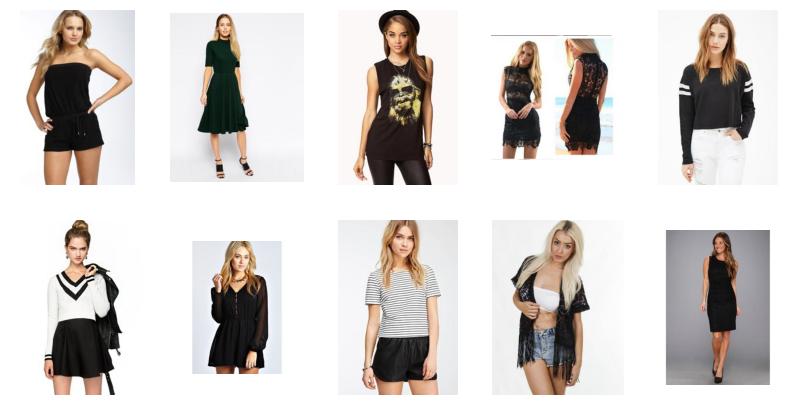

In [46]:
show_images(top)

### Генерация рекомендаций пользователю

In [116]:
clothes[clothes["clothes_id"] == 1743]['image_id']

34    img/Colorblocked_Chevron_Knit_Sweater/img_0000...
Name: image_id, dtype: object

In [129]:
rated_clothes = [3517,    
                 1486,    
                 6289,
                 1316]

rated_clothes_name = []

for i in rated_clothes:
    rated_clothes_name.append((clothes[clothes["clothes_id"] == i]['image_id']).to_string(index=False))

rated_clothes_name

['img/Floral_Print_Mock_Neck_Dress/img_00000057.jpg',
 'img/Classic_High-Waisted_Jeans/img_00000005.jpg',
 'img/Sheer-Sleeved_Pleated_Romper/img_00000004.jpg',
 'img/Chiffon_Maxi_Cardigan/img_00000028.jpg']

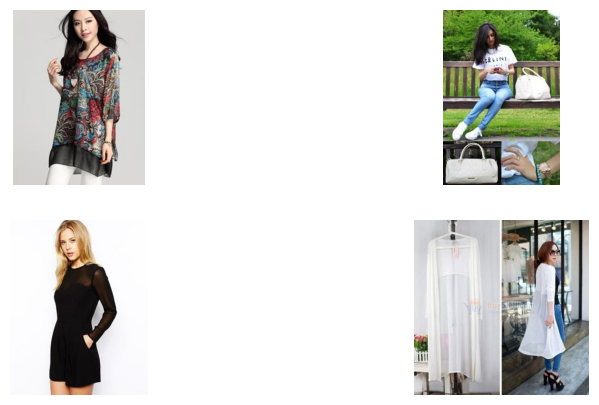

In [130]:
show_images(clothes_name)

In [135]:
# Для генерации рекомендаций новому пользователю, 
# берем его одежду и оценки и складываем в "мега"-эмбеддинг,
# а затем проводим поиск самых схожих среди всех фильмов.

user_rate = 0.8 # 4/5 каждой одежде

mega_embedding = 0

for rated in rated_clothes:
    mega_embedding += user_rate * (model.embeddings(torch.tensor(rated, device=device)))
    
rankings = clothes_biases.squeeze() + (mega_embedding * clothes_embeddings).sum(1)
top2 = [i for i in clothes.iloc[rankings.argsort(descending=True).cpu()]['image_id'].values]
top2 = [i for i in top2 if i not in rated_clothes_name][:10]

In [136]:
top2

['img/Abstract_Organza_A-Line_Skirt/img_00000012.jpg',
 'img/Side-Slit_Maxi_Dress/img_00000047.jpg',
 'img/Abstract_Paint_Splatter_Blouse/img_00000025.jpg',
 'img/Colorblocked_Chevron_Knit_Sweater/img_00000011.jpg',
 'img/Dip-Dyed_Trapeze_Tee/img_00000028.jpg',
 'img/Be_True_Graphic_Tunic_Tank/img_00000021.jpg',
 'img/Heathered_Stripe_Romper/img_00000018.jpg',
 'img/Heathered_Knit_Pencil_Skirt/img_00000007.jpg',
 'img/Crochet_Cami_Strap_Dress/img_00000009.jpg',
 'img/Kimono-Sleeved_Paisley_Blouse/img_00000111.jpg']

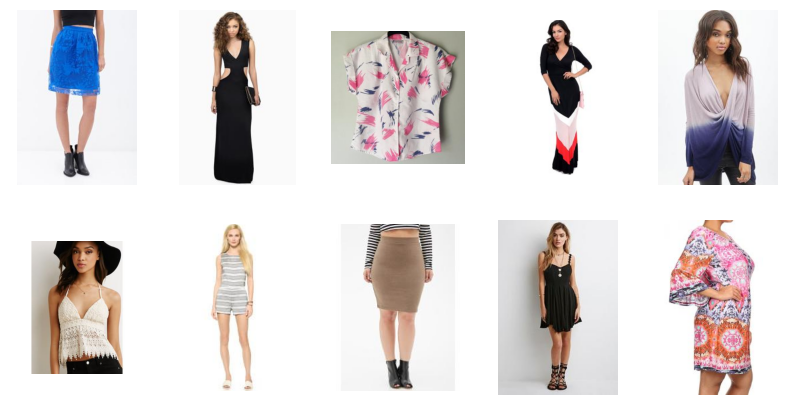

In [137]:
show_images(top2)

In [138]:
torch.save(model.state_dict(), "/kaggle/working/clothes_recsys_model")

# Перспективы и что можно было сделать лучше

## Источники

1. Rendle S. Factorization machines //2010 IEEE International conference on data mining. – IEEE, 2010. – С. 995-1000. - а также github с имплементацией идей статьи: https://github.com/yonigottesman/recommendation_playground/blob/master/fm_movies.ipynb
2. https://blog.fastforwardlabs.com/2018/04/10/pytorch-for-recommenders-101.html - обзор и сравнение Matrix Factorization, Dense Feedforward NN, Sequence based RecSys
3. https://www.linkedin.com/pulse/how-implement-recommendation-system-deep-learning-pytorch-zaitsev - разбор на PyTorch реализации fast.ai RecSys
4. https://github.com/rposhala/Recommender-System-on-MovieLens-dataset#recommender-system-using-softmax-deep-neural-networks - Recommender System using Softmax Deep Neural Networks на TensorFlow